## Note au jury — prévision de prix

Notebook dédié à la prédiction de prix/retours via modèles ML simples. Les notes rendent explicite le protocole expérimental.


# Prédiction de prix — ML basique

On prépare un dataset de séries boursières, construit quelques features, puis entraîne un modèle supervisé. L'accent est mis sur la validation temporelle et la lecture des métriques.


## Méthodologie

- Données : historiques (train/test séparés dans le temps).
- Features : retours, moyennes mobiles, indicateurs simples.
- Modèle : régression ou classification de direction.
- Évaluation : MSE ou accuracy, plus PnL simulé en post-traitement.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
import tensorflow
import sklearn
import keras
import yfinance as yf





from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor



#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.optimizers import SGD
from keras.src.layers import LSTM, Dense


from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# Extraction des données boursières pour les actions
try:
    stk_data = yf.download(stk_tickers, start="2020-01-01", end="2023-01-01")
    print("Données boursières téléchargées :")
    print(stk_data.head())
except Exception as e:
    print(f"Erreur lors de l'extraction des données boursières : {e}")

# Remarque : Pour FRED, utiliser pandas_datareader comme pour DEXJPUS ou d'autres données économiques
from pandas_datareader import data as web

try:
    ccy_data = web.DataReader(ccy_tickers, 'fred')
    idx_data = web.DataReader(idx_tickers, 'fred')
    print("Données FRED téléchargées :")
    print(ccy_data.head())
    print(idx_data.head())
except Exception as e:
    print(f"Erreur lors de l'extraction des données de FRED : {e}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Données boursières téléchargées :
Price           Close                               High              \
Ticker          GOOGL         IBM        MSFT      GOOGL         IBM   
Date                                                                   
2020-01-02  67.965233  100.565193  152.791107  67.965233  100.936502   
2020-01-03  67.609695   99.763161  150.888626  68.217010  100.149321   
2020-01-06  69.411751   99.584938  151.278656  69.437074   99.688898   
2020-01-07  69.277695   99.651764  149.899292  69.694323  100.223585   
2020-01-08  69.770775  100.483498  152.286972  70.108942  100.891941   

Price                         Low                               Open  \
Ticker            MSFT      GOOGL         IBM        MSFT      GOOGL   
Date                                                                   
2020-01-02  152.895746  66.863336  100.082493  150.612732  66.958679   
2020-01-03  152.153802  66.904560   99.183914  150.355924  66.938331   
2020-01-06  151.345251  67.08

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [4]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [5]:
Y = np.log(stk_data.loc[:, ('Volume', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Volume', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Volume', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

print(stk_data.columns)

MultiIndex([( 'Close', 'GOOGL'),
            ( 'Close',   'IBM'),
            ( 'Close',  'MSFT'),
            (  'High', 'GOOGL'),
            (  'High',   'IBM'),
            (  'High',  'MSFT'),
            (   'Low', 'GOOGL'),
            (   'Low',   'IBM'),
            (   'Low',  'MSFT'),
            (  'Open', 'GOOGL'),
            (  'Open',   'IBM'),
            (  'Open',  'MSFT'),
            ('Volume', 'GOOGL'),
            ('Volume',   'IBM'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [6]:
pd.set_option('display.precision', 3)
dataset = pd.DataFrame(dataset)
print(dataset.describe())

       MSFT_pred    GOOGL      IBM  DEXJPUS    DEXUSUK    SP500       DJIA  \
count    104.000  104.000  104.000  104.000  1.040e+02  104.000  1.040e+02   
mean       0.006    0.045    0.027    0.003 -1.101e-03    0.001  1.615e-03   
std        0.410    0.437    0.587    0.012  1.050e-02    0.025  2.234e-02   
min       -1.401   -1.138   -2.097   -0.042 -4.063e-02   -0.082 -7.057e-02   
25%       -0.222   -0.229   -0.237   -0.004 -6.942e-03   -0.014 -1.180e-02   
50%       -0.012    0.037   -0.026    0.002 -8.116e-04    0.003  7.755e-04   
75%        0.212    0.274    0.297    0.008  5.343e-03    0.017  1.505e-02   
max        1.430    1.388    2.217    0.040  2.512e-02    0.070  7.967e-02   

          VIXCLS  MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
count  1.040e+02  104.000   104.000   104.000    104.000  
mean  -5.749e-04    0.017    -0.011    -0.020     -0.012  
std    1.443e-01    0.405     0.451     0.383      0.465  
min   -3.660e-01   -0.894    -1.002    -1.083     -1.180  
25

In [7]:
print(dataset.head())

            MSFT_pred  GOOGL    IBM    DEXJPUS  DEXUSUK  SP500       DJIA  \
2020-10-08      0.132 -0.232  2.064  4.255e-03    0.003  0.019  2.164e-02   
2020-10-16     -0.322  0.037 -0.573 -2.937e-03   -0.006  0.002  6.788e-04   
2020-10-26     -0.185  0.186 -0.038 -5.326e-03    0.002 -0.008 -1.826e-02   
2020-11-02      0.364  0.211 -0.305 -5.724e-04   -0.009 -0.027 -2.785e-02   
2020-11-09     -0.576  0.189  0.526  7.415e-03    0.018  0.070  7.967e-02   

            VIXCLS  MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
2020-10-08  -0.013   -0.310    -0.535    -0.687     -0.479  
2020-10-16   0.092   -0.015    -0.122    -0.807     -0.951  
2020-10-26   0.107    0.295     0.554     0.200     -0.319  
2020-11-02   0.134   -0.185    -0.271    -0.256      0.103  
2020-11-09  -0.366    0.364     0.474     0.327      0.905  


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

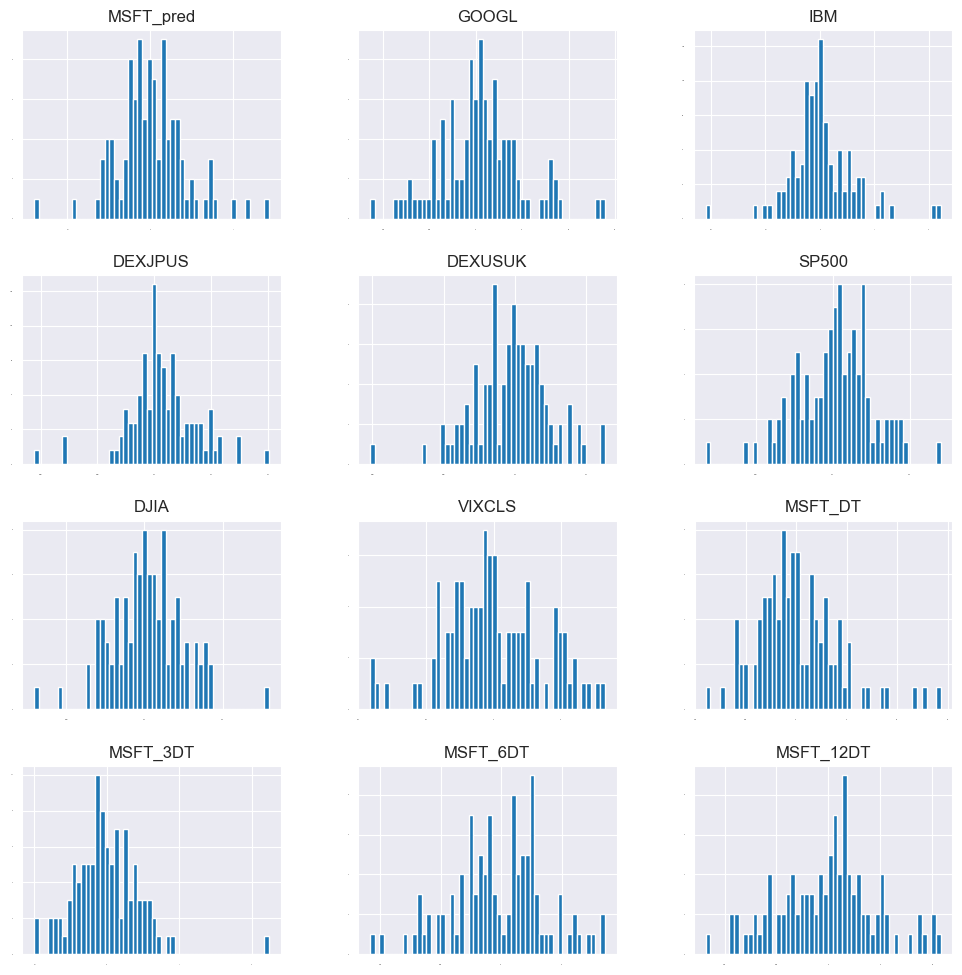

In [8]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

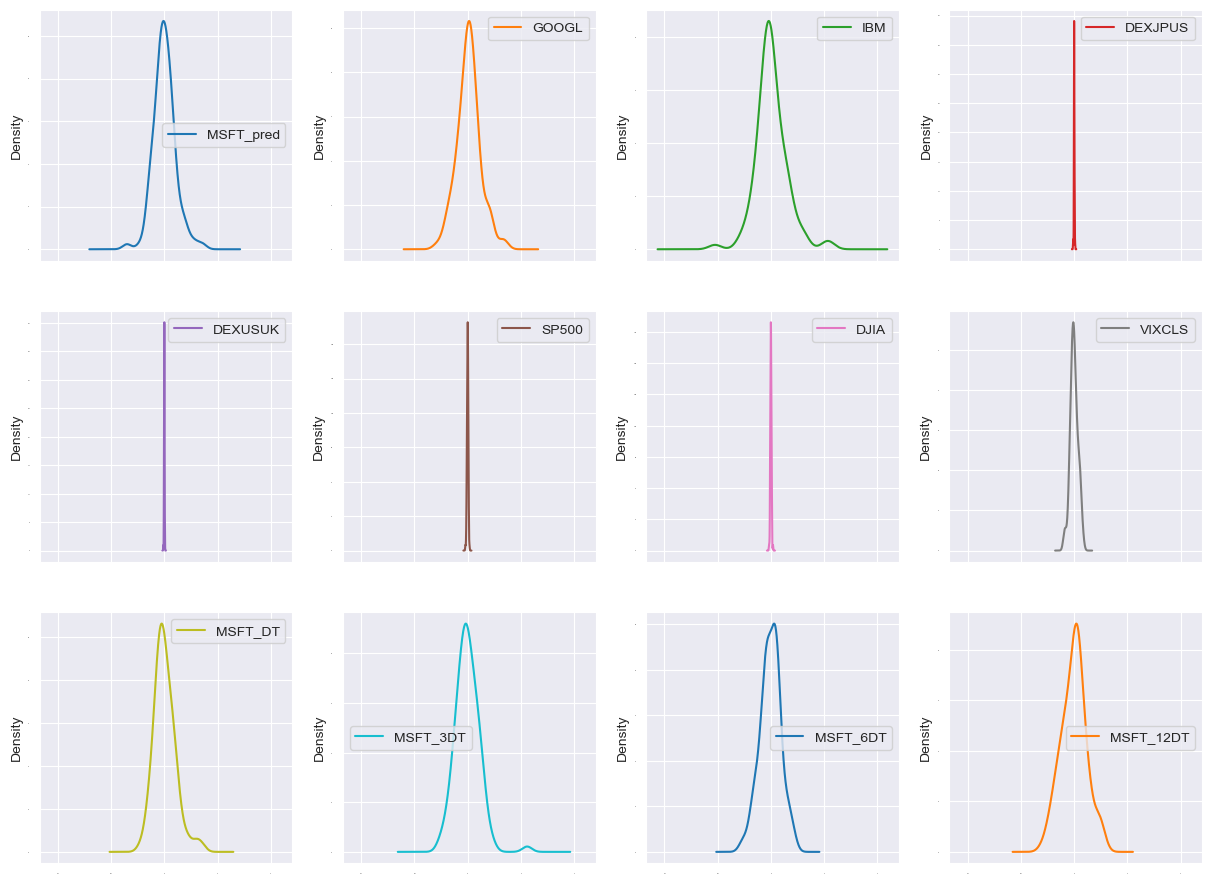

In [9]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<Axes: title={'center': 'Correlation Matrix'}>

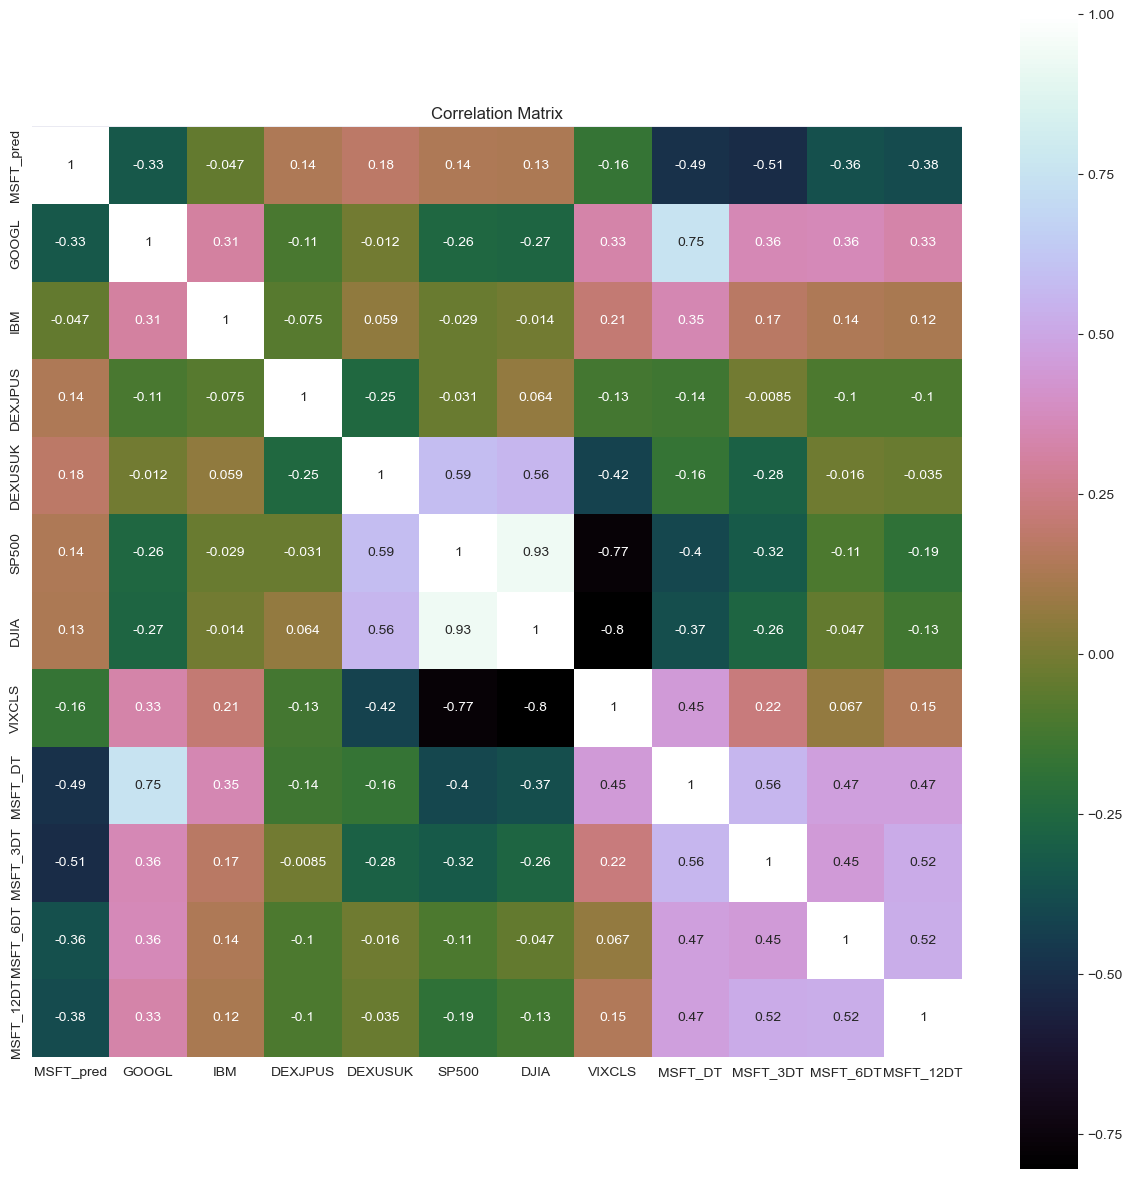

In [10]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1500x1500 with 0 Axes>

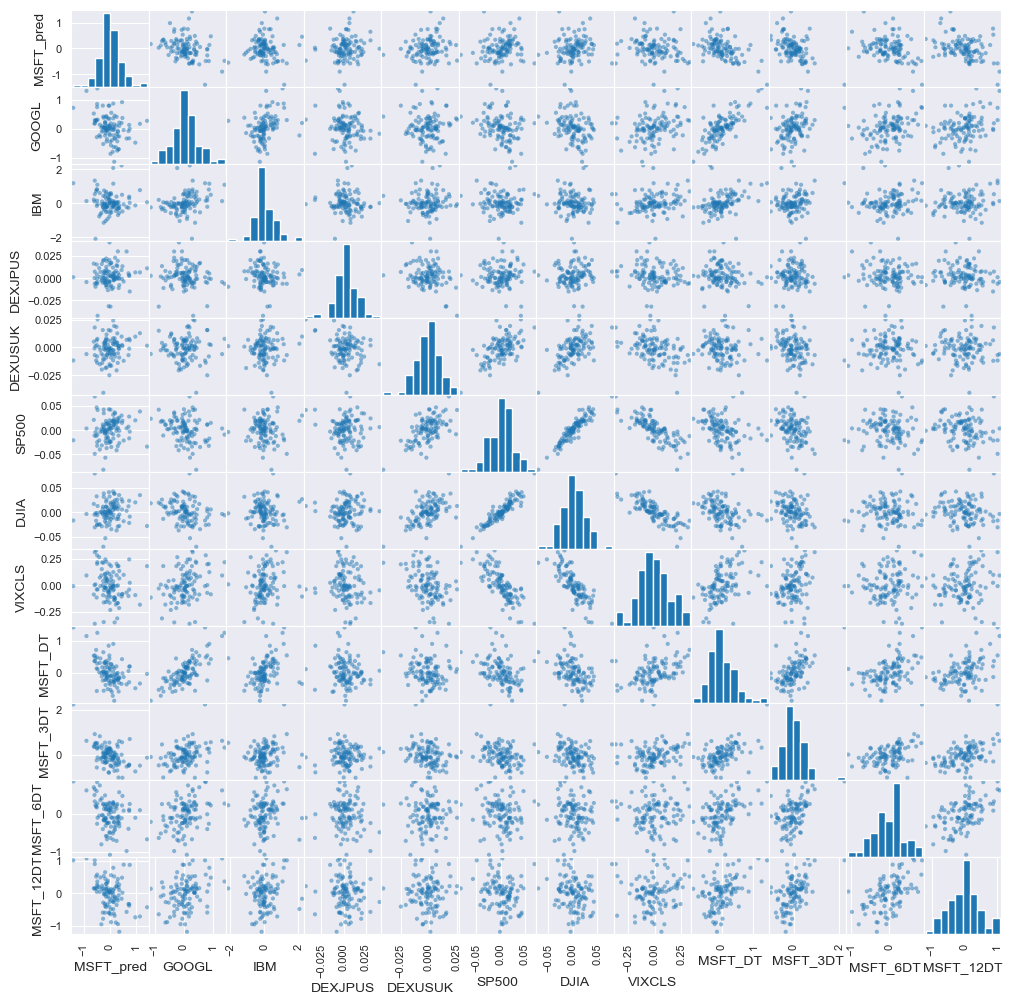

In [11]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

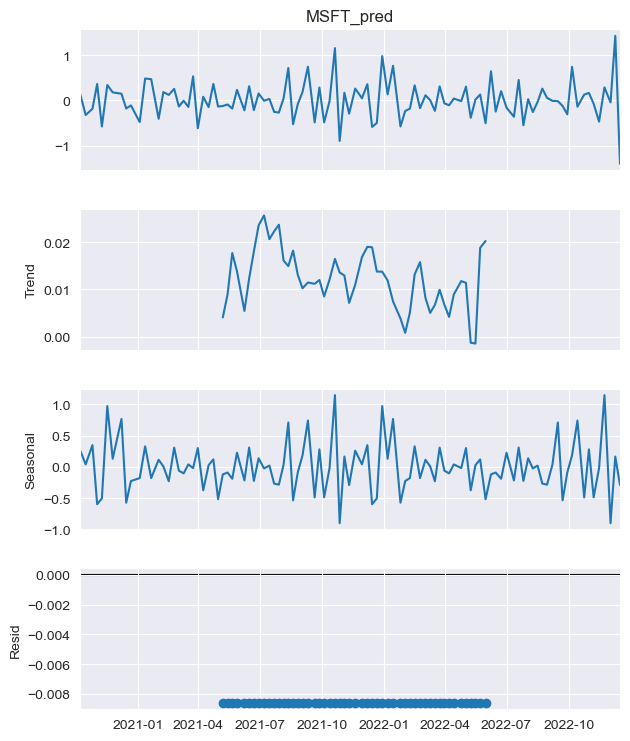

In [12]:


# Supposons que Y soit votre série temporelle définie
res = sm.tsa.seasonal_decompose(Y, period=52)  # Remplacer 'freq' par 'period'
fig = res.plot()
fig.set_figheight(8)

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [13]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_3DT,35.677
MSFT_DT,32.220
MSFT_12DT,17.518
MSFT_6DT,15.547
GOOGL,12.215
DEXUSUK,3.335
VIXCLS,2.793
SP500,1.956
DEXJPUS,1.954


We see that IBM seems to be the most important feature and vix being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [14]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
#train_size = int(len(X) * (1-validation_size))
#X_train, X_test = X[0:train_size], X[train_size:len(X)]
#Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [15]:
num_folds = 10

# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [16]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

##### Neural Network algorithms

##### Ensable Models

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [17]:
from sklearn.model_selection import  LeaveOneOut
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    #converted mean square error to positive. The lower the better
    # Adjuster `num_folds` dynamiquement si nécessaire
    if len(X_train) < num_folds:
        print(f"Réduction du nombre de plis à {len(X_train)}, car le nombre d'échantillons est insuffisant.")
        num_folds = len(X_train)
    # Validation croisée
    if num_folds > 1:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    else:
        # Option alternative : Leave-One-Out si trop peu d'échantillons
        print("Passage au Leave-One-Out en raison du faible nombre d'échantillons.")
        loo = LeaveOneOut()
        cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=loo, scoring=scoring)

    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    res = model.fit(X_train, Y_train)
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.125777 (0.087870) 0.094755 0.149305
LASSO: 0.156478 (0.125587) 0.152607 0.220518
EN: 0.156478 (0.125587) 0.152607 0.220518
KNN: 0.143276 (0.121459) 0.095982 0.164760
CART: 0.213601 (0.127073) 0.000000 0.364626
SVR: 0.152274 (0.144069) 0.070592 0.257780
MLP: 0.141092 (0.105007) 0.059495 0.189039
ABR: 0.135629 (0.104666) 0.032571 0.211154
GBR: 0.133369 (0.095949) 0.000886 0.287683
RFR: 0.124344 (0.105583) 0.018320 0.197430
ETR: 0.123204 (0.101012) 0.000000 0.182524


#### K Fold results

We being by looking at the K Fold results

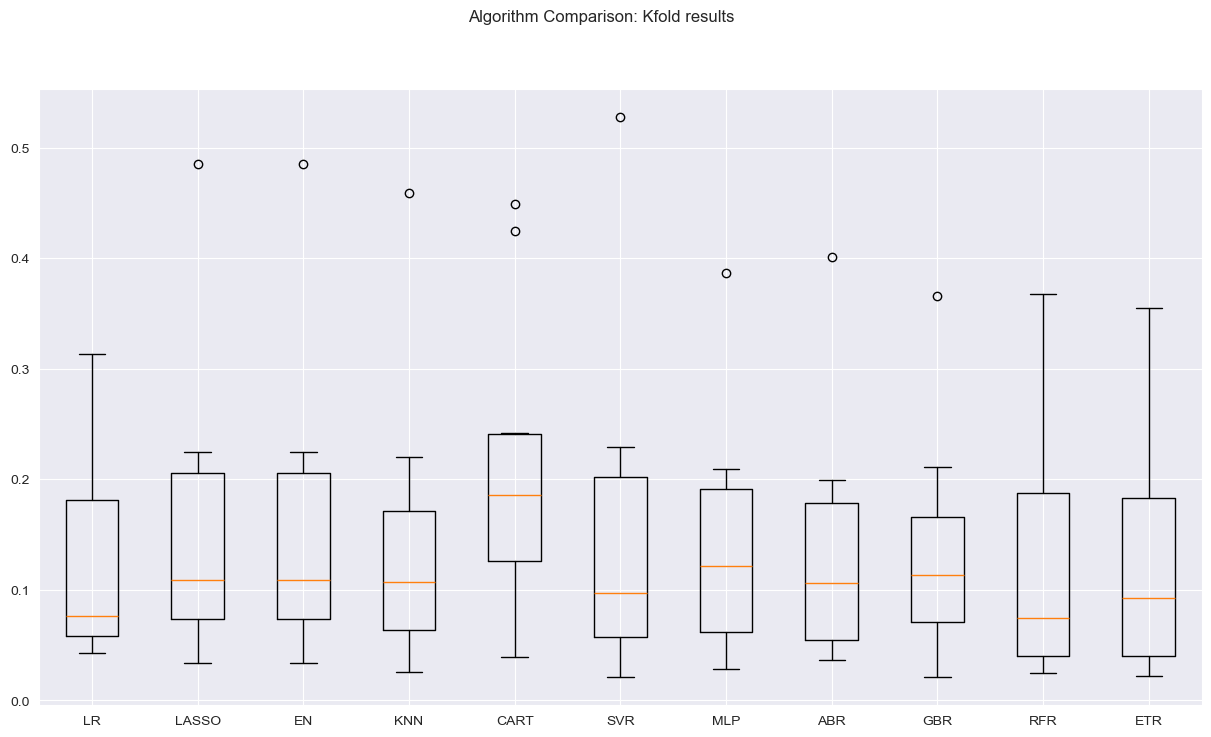

In [18]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

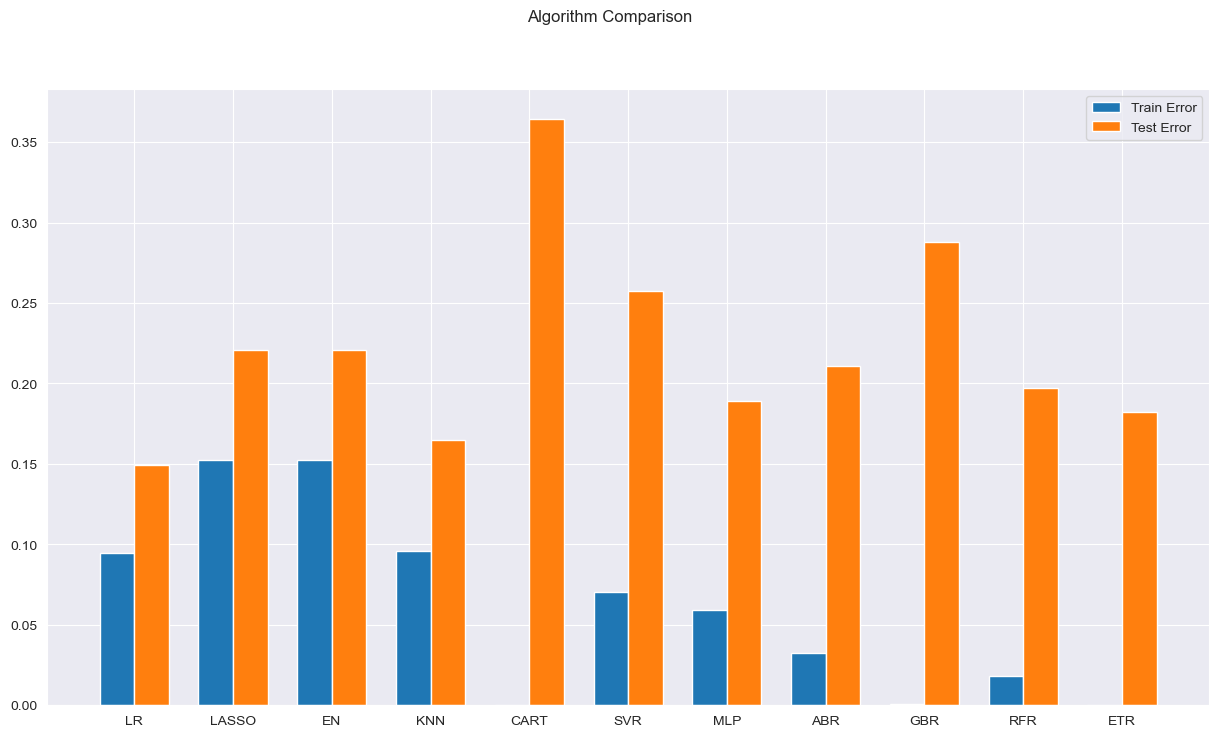

In [19]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [20]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [21]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [22]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.21256535835401982

###  LSTM Model

In [23]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [24]:

# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    model = Sequential()

    # Ajoute une couche LSTM avec 50 cellules (neurones) et une forme d'entrée spécifique
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

    # Ajoute une couche dense (de sortie avec activation linéaire par défaut ici)
    model.add(Dense(1))

    # Configure l'optimiseur SGD avec les paramètres appris
    #optimizer = SGD(lr=learn_rate, momentum=momentum)

    # Compile le modèle avec une perte quadratique moyenne (mse) en utilisant un autre optimiseur ('adam')
    model.compile(loss='mse', optimizer='adam')
    return model


# Création du modèle
LSTMModel = create_LSTMmodel(12, learn_rate=0.01, momentum=0.0)

# entraînement du modèle
LSTMModel_fit = LSTMModel.fit(
    X_train_LSTM,
    Y_train_LSTM,
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330,
    batch_size=72,
    verbose=0,
    shuffle=False
)


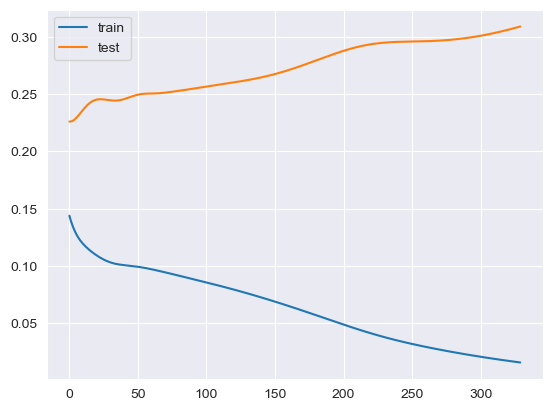

In [25]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


#### Append to previous results

In [27]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

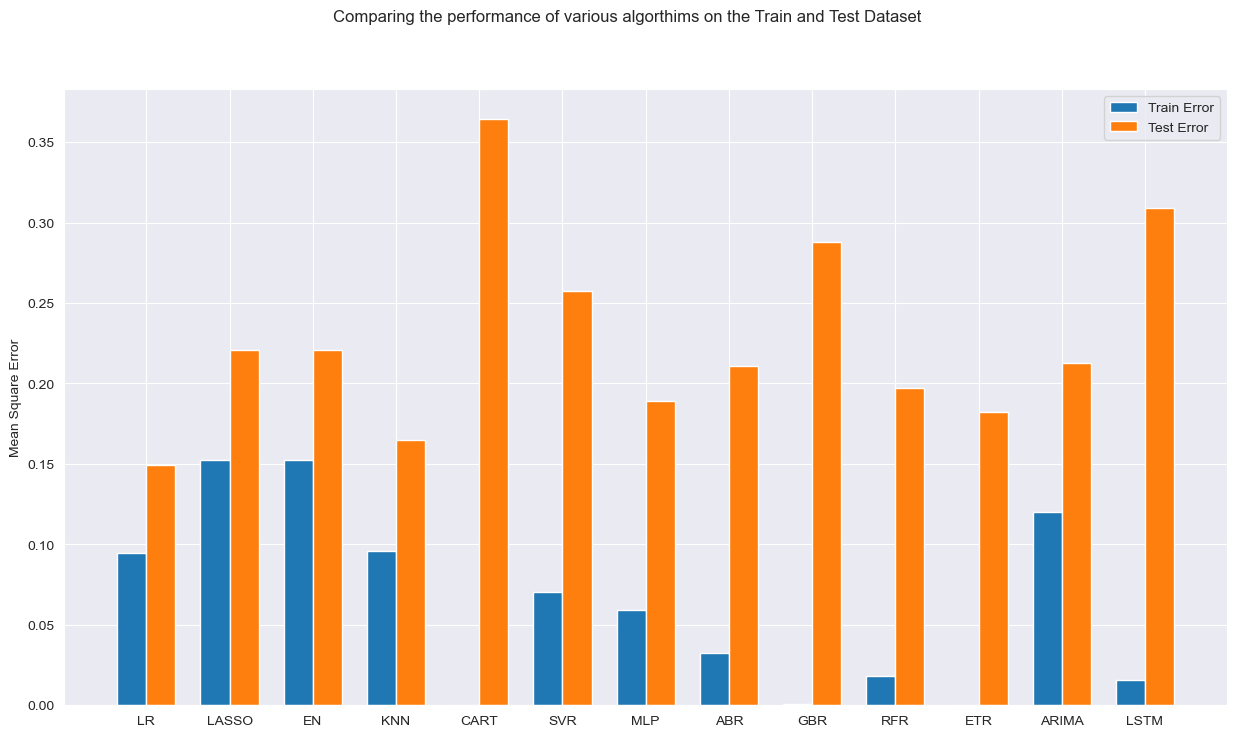

In [28]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [29]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.1300342
ARIMA(0, 0, 1) MSE=0.1204871
ARIMA(0, 1, 0) MSE=0.1850136
ARIMA(0, 1, 1) MSE=0.1377640
ARIMA(1, 0, 0) MSE=0.1198378
ARIMA(1, 0, 1) MSE=0.1197936
ARIMA(1, 1, 0) MSE=0.1663157
ARIMA(1, 1, 1) MSE=0.1264875
ARIMA(2, 0, 0) MSE=0.1196557
ARIMA(2, 0, 1) MSE=0.1190058
ARIMA(2, 1, 0) MSE=0.1602689
ARIMA(2, 1, 1) MSE=0.1263716
Best ARIMA(2, 0, 1) MSE=0.1190058


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [30]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [31]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.21256535835401982


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [32]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = '../finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

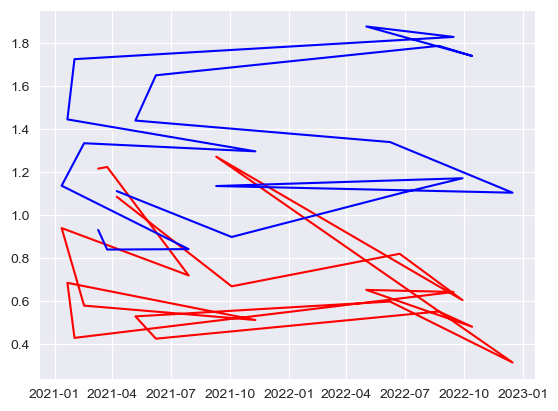

In [33]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

### Summary

## Synthèse

Les performances montrent la sensibilité aux features et au découpage temporel. Avant un usage réel : validation walk-forward, prise en compte des coûts et contrôle du risque.
